<a href="https://colab.research.google.com/github/CanopySimulations/canopy-python-examples/blob/master/converting_bump_stops_from_lookup_to_parametric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upgrade Runtime
This cell ensures the runtime supports `asyncio` async/await, and is needed on Google Colab. If the runtime is upgraded, you will be prompted to restart it, which you should do before continuing execution.

In [ ]:
!pip install "ipython>=7"

# Set Up Environment

### Import required libraries

In [1]:
!pip install -q canopy

     |████████████████████████████████| 133kB 6.3MB/s 
     |████████████████████████████████| 1.3MB 24.7MB/s 
     |████████████████████████████████| 296kB 52.9MB/s 
     |████████████████████████████████| 143kB 47.0MB/s 


In [2]:
import canopy
import logging
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import nest_asyncio

logging.basicConfig(level=logging.INFO)
nest_asyncio.apply()

### Authenticate

In [ ]:
authentication_data = canopy.prompt_for_authentication()
session = canopy.Session(authentication_data)

# Set Up Example

Load an example car and set the front internal bump stop to a lookup. The sample lookup was created by eye-balling the chart in the Canopy [documentation page](https://portal.canopysimulations.com/wiki/Suspension;location=tab-bumpstopparameters).

> **Tip: `dict_to_object`**
> 
> We are using the helper function `dict_to_object` to convert the bump stop from a dictionary, which we would access as `bump_stop['xData']`, to an object which we can access as `bump_stop.xData`. This isn't necessary, but is quite convenient.

> **Tip: `session.units`**
>
> The `session.units` object contains useful functions for converting single values, array and Pandas Series between units.

In [4]:
input_car = await canopy.load_default_config(
    session,
    'car',
    'Canopy F1 Car 2019')

x_mm = np.array([0, 2, 4, 6, 8, 10, 11])
f_N = [0, 10, 30, 100, 800, 3200, 7000]

bump_stop = canopy.dict_to_object({
    'name': 'Bump-stop LU',
    'xData': session.units.convert_array_to_si(x_mm, 'mm'),
    'FData': f_N,
    'xFreeGap': session.units.convert_value_to_si(5, 'mm'),
    'freeGapReferenceCondition': 'Setup'})

input_car.data.suspension.front.internal.bumpStop = bump_stop

bump_stop

Munch({'name': 'Bump-stop LU', 'xData': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.011]), 'FData': [0, 10, 30, 100, 800, 3200, 7000], 'xFreeGap': 0.005, 'freeGapReferenceCondition': 'Setup'})

# Example: Convert bump-stop from lookup to parametric

First we use the [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function from the SciPy library to find some appropriate parameters.

In [5]:
bump_stop = input_car.data.suspension.front.internal.bumpStop

x_m = np.array(bump_stop.xData)
f_N = np.array(bump_stop.FData).astype(float)

def func(x, pLinear, pExponential, pExponentialScaling):
    return pLinear * x + pExponentialScaling * np.exp(pExponential * x)

popt, pcov = curve_fit(func, x_m, f_N)
pLinear, pExponential, pExponentialScaling = popt
popt

array([2.76108942e+03, 7.71831455e+02, 1.42961520e+00])

We can visually check the fit by running the parameters back through our function and plotting the results against the original lookup.

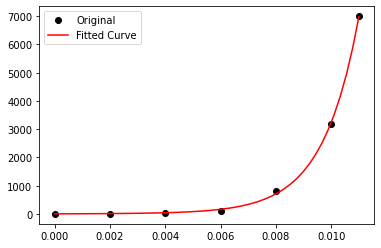

In [6]:
x_linspace = np.linspace(min(x_m), max(x_m), 50)
f_linspace = func(x_linspace, pLinear, pExponential, pExponentialScaling)

plt.figure()
plt.plot(x_m, f_N, 'ko', label="Original")
plt.plot(x_linspace, f_linspace, 'r-', label="Fitted Curve")
plt.legend()
plt.show()

The fit looks good, so we can create a new bump stop...

In [7]:
new_bump_stop = {
    'name': 'Parametric bump-stop',
    'pLinear': pLinear,
    'pExponential': pExponential,
    'pExponentialScaling': pExponentialScaling,
    'freeGapReferenceCondition': bump_stop.freeGapReferenceCondition,
    'xFreeGap': bump_stop.xFreeGap,
}

new_bump_stop

{'name': 'Parametric bump-stop',
 'pLinear': 2761.0894198218516,
 'pExponential': 771.8314554938751,
 'pExponentialScaling': 1.429615203397796,
 'freeGapReferenceCondition': 'Setup',
 'xFreeGap': 0.005}

... then replace the bump stop on the car and save a new car back to the platform.

In [8]:
input_car.data.suspension.front.internal.bumpStop = new_bump_stop

new_config_id = await canopy.create_config(
    session,
    'car',
    input_car.name + ' Parametric Fit Example',
    input_car.data,
    input_car.properties,
    input_car.notes)
    
new_config_id